In [1]:
data = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv"

In [ ]:
!wget $data

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv("laptops.csv")
df.head()

,Laptop,Status,Brand,Model,CPU,RAM,Storage,Storage type,GPU,Screen,Touch,Final Price
0,ASUS ExpertBook B1 B1502CBA-EJ0436X Intel Core...,New,Asus,ExpertBook,Intel Core i5,8,512,SSD,NaN,15.6,No,1009.00
1,Alurin Go Start Intel Celeron N4020/8GB/256GB ...,New,Alurin,Go,Intel Celeron,8,256,SSD,NaN,15.6,No,299.00
2,ASUS ExpertBook B1 B1502CBA-EJ0424X Intel Core...,New,Asus,ExpertBook,Intel Core i3,8,256,SSD,NaN,15.6,No,789.00
3,MSI Katana GF66 12UC-082XES Intel Core i7-1270...,New,MSI,Katana,Intel Core i7,16,1000,SSD,RTX 3050,15.6,No,1199.00
4,HP 15S-FQ5085NS Intel Core i5-1235U/16GB/512GB...,New,HP,15S,Intel Core i5,16,512,SSD,NaN,15.6,No,669.01


In [3]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [4]:
columns = ['ram','storage','screen','final_price']

In [5]:
df  = df[columns]
df

,ram,storage,screen,final_price
0,8,512,15.6,1009.00
1,8,256,15.6,299.00
2,8,256,15.6,789.00
3,16,1000,15.6,1199.00
4,16,512,15.6,669.01
...,...,...,...,...
2155,16,1000,17.3,2699.99
2156,16,1000,17.3,2899.99
2157,32,1000,17.3,3399.99
2158,16,1000,13.4,1899.99


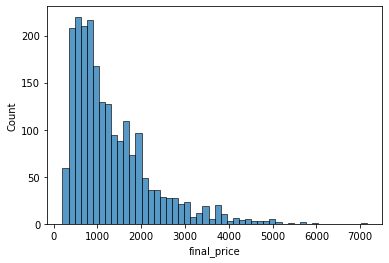

In [6]:
# final price without normilization
sns.histplot(df.final_price, bins = 50);

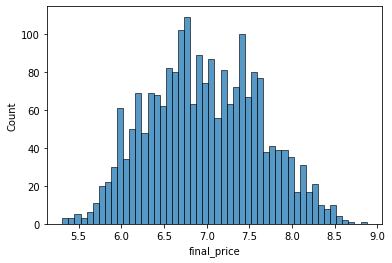

In [7]:
# final price with normalization
sns.histplot(np.log1p(df.final_price), bins = 50);

In [8]:
# missing values
df.isnull().sum()

ram            0
storage        0
screen         4
final_price    0
dtype: int64

In [9]:
df.describe()

,ram,storage,screen,final_price
count,2160.000000,2160.000000,2156.000000,2160.000000
mean,15.413889,596.294444,15.168112,1312.638509
std,9.867815,361.220506,1.203329,911.475417
min,4.000000,0.000000,10.100000,201.050000
25%,8.000000,256.000000,14.000000,661.082500
50%,16.000000,512.000000,15.600000,1031.945000
75%,16.000000,1000.000000,15.600000,1708.970000
max,128.000000,4000.000000,18.000000,7150.470000


In [10]:
# split dataset 
n = len(df)
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

In [11]:
n,n_val,n_test,n_train

(2160, 432, 432, 1296)

In [12]:
#subset dataset

#shuffle the dataset
idx = np.arange(n)
np.random.seed(42)
np.random.shuffle(idx)

df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train + n_val]]
df_test = df.iloc[idx[n_val + n_train:]]

In [13]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_val = df_test.reset_index(drop=True)

In [14]:
# collect our target variable

y_train = df_train.final_price.values
y_val = df_val.final_price.values
y_test = df_test.final_price.values

In [15]:
del df_train['final_price']
del df_test['final_price']
del df_val['final_price']

In [16]:
def prepare_x_fill_zeros(df):
    df = df.copy()
    

    df = df.fillna(0)
    
    X = df.values

    return X

In [17]:
def prepare_x_fill_mean(df):
    df = df.copy()
    
    mean = df['screen'].mean()
    df = df.fillna(value=mean)
    
    X = df.values

    return X

#### Linear Regression

In [18]:
def dot(xi, w):
    
    n = len(xi)

    res = 0.0 

    for j in range(n):
        res = res + xi[j] * w[j]
    
    return res

In [19]:
def train_linear_regression(X,y):
    
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones,X]).round()

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)

    return w_full[0],w_full[1:]

In [20]:
# function to calculate the root mean squared error
def rmse(y,y_pred):
    error = y - y_pred
    se = error ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [21]:
# training the model with X_train
X_train = prepare_x_fill_zeros(df_train)

w0,w = train_linear_regression(X_train,y_train)
y_pred = w0 + X_train.dot(w)

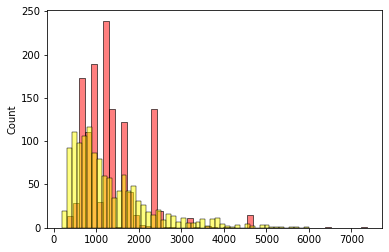

In [26]:
sns.histplot(y_pred, color="red", alpha=0.5, bins = 50)
sns.histplot(y_train, color = "yellow", alpha=0.5,bins = 50);

In [27]:
# using the fillna with 0
X_train = prepare_x_fill_zeros(df_train)

w0,w = train_linear_regression(X_train,y_train)
# y_pred = w0 + X_train.dot(w)

X_val = df_val.values
y_pred = w0 + X_val.dot(w)

score = rmse(y_val,y_pred)
round(score,2)

547.88

In [28]:
# using the fillna with mean
X_train = prepare_x_fill_mean(df_train)

w0,w = train_linear_regression(X_train,y_train)
# y_pred = w0 + X_train.dot(w)

X_val = df_val.values
y_pred = w0 + X_val.dot(w)

score = rmse(y_val,y_pred)
round(score,2)

548.88

In [29]:
def train_linear_regression_reg(X,y,r = 0.01):
    
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones,X]).round()

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)

    return w_full[0],w_full[1:]

In [31]:
for r in [0, 0.01, 0.1, 1, 5, 10, 100]:
    w_0, w = train_linear_regression_reg(X_train, y_train, r=r)

    print(f"r:{r}")
    y_pred = w_0 + X_train.dot(w)
    print('train', round(rmse(y_train, y_pred),2))

    X_val = prepare_x_fill_zeros(df_val)
    y_pred = w_0 + X_val.dot(w)
    print('val', round(rmse(y_val, y_pred),5))
    print('\n')

r:0
train 602.63
val 548.88156


r:0.01
train 602.63
val 548.87447


r:0.1
train 602.59
val 548.81202


r:1
train 602.37
val 548.30199


r:5
train 602.25
val 547.36438


r:10
train 602.61
val 547.18493


r:100
train 604.76
val 548.10479




In [32]:
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

rmse_vals = []

for seed in seeds:
    np.random.seed(seed)

    idx = np.arange(n)

    np.random.shuffle(idx)

    df_val = df.iloc[idx[:n_val]]

    df_test = df.iloc[idx[n_val:n_val + n_test]]

    df_train = df.iloc[idx[n_val + n_test:]]

    y_train = df_train['final_price'].values
    y_test = df_test['final_price'].values
    y_val = df_val['final_price'].values

    del df_train['final_price']

    del df_test['final_price'] 

    del df_val['final_price']

    X_train = prepare_x_fill_zeros(df_train)
    w_0, w = train_linear_regression(X_train, y_train)
    
    y_pred = w_0 + X_train.dot(w)

    X_val = prepare_x_fill_zeros(df_val)
    y_pred_val = w_0 + X_val.dot(w)

    rmse_vals.append(rmse(y_val,y_pred_val))

round(np.std(rmse_vals), 3)

27.555

In [35]:
np.random.seed(9)

idx = np.arange(n)

np.random.shuffle(idx)

df_val = df.iloc[idx[:n_val]]

df_test = df.iloc[idx[n_val:n_val + n_test]]

df_train = df.iloc[idx[n_val + n_test:]]

y_train = df_train['final_price'].values
y_test = df_test['final_price'].values
y_val = df_val['final_price'].values

del df_train['final_price']

del df_test['final_price'] 

del df_val['final_price']

full_train = pd.concat([df_train,df_val])

df_full_train = full_train.reset_index(drop=True)

X_full_train = prepare_x_fill_zeros(df_full_train)

y_full_train = np.concatenate([y_train,y_val])

w0,w = train_linear_regression_reg(X_full_train,y_full_train, r=0.001)

X_test = prepare_x_fill_zeros(df_test)

y_pred = w0 + X_test.dot(w)

score = rmse(y_test,y_pred)

score

674.3359072001355